In [1]:
!pip install -U tensorflow_hub
!pip install tf-nightly-gpu

Requirement already up-to-date: tensorflow_hub in /home/badc0ded/anaconda3/envs/colab/lib/python3.6/site-packages (0.5.0)


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [3]:
import matplotlib.pylab as plt
import tensorflow as tf
tf.enable_eager_execution()
import tensorflow_hub as hub
from tensorflow.keras import layers
import numpy as np
import PIL.Image as Image
import time
import os

W0727 13:58:05.473922 139777020905280 module_wrapper.py:136] From /home/badc0ded/anaconda3/envs/colab/lib/python3.6/site-packages/tensorflow_core/python/util/module_wrapper.py:163: The name tf.enable_eager_execution is deprecated. Please use tf.compat.v1.enable_eager_execution instead.



In [4]:
os.environ['DATA_PATH'] = '/home/badc0ded/notebooks/data'

In [5]:
DATA_PATH = os.environ.get('DATA_PATH')

IMAGE_SHAPE = (224, 224)

In [6]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()


def read_data(data_root):
  image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1 / 255)
  image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)
  return image_data


def plot_predicted_batch(image_batch, label_batch, predicted_batch):
  predicted_id = np.argmax(predicted_batch, axis=-1)
  predicted_label_batch = class_names[predicted_id]
  label_id = np.argmax(label_batch, axis=-1)
  plt.figure(figsize=(10, 9))
  plt.subplots_adjust(hspace=0.5)
  for n in range(30):
    plt.subplot(6, 5, n + 1)
    plt.imshow(image_batch[n])
    color = "green" if predicted_id[n] == label_id[n] else "red"
    plt.title(predicted_label_batch[n].title(), color=color)
    plt.axis('off')
  _ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

In [7]:
train_data_root = os.path.join(DATA_PATH, "train")
train_image_data = read_data(train_data_root)
train_image_batch, train_label_batch = train_image_data[0]

Found 11390 images belonging to 2 classes.


In [8]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" #@param {type:"string"}
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=IMAGE_SHAPE + (3,))
feature_extractor_layer(train_image_batch)
feature_extractor_layer.trainable = False

In [9]:
model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(train_image_data.num_classes, activation='softmax')
])

model.summary()

W0727 13:58:11.955031 139777020905280 module_wrapper.py:136] From /home/badc0ded/anaconda3/envs/colab/lib/python3.6/site-packages/tensorflow_core/python/util/module_wrapper.py:163: The name tf.estimator.inputs is deprecated. Please use tf.compat.v1.estimator.inputs instead.



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [10]:
predictions = model(train_image_batch)
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

steps_per_epoch = np.ceil(train_image_data.samples/train_image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit(train_image_data, epochs=2,
                    steps_per_epoch=steps_per_epoch,
                    callbacks=[batch_stats_callback])


W0727 13:58:14.085890 139777020905280 deprecation.py:323] From /home/badc0ded/anaconda3/envs/colab/lib/python3.6/site-packages/tensorflow_core/python/ops/math_grad.py:1366: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/2


W0727 13:58:14.221128 139777020905280 deprecation.py:323] From /home/badc0ded/anaconda3/envs/colab/lib/python3.6/site-packages/tensorflow_core/python/keras/optimizer_v2/optimizer_v2.py:468: BaseResourceVariable.constraint (from tensorflow.python.ops.resource_variable_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Apply a constraint manually following the optimizer update step.


356/356 [==============================] - 350s 982ms/step - loss: 0.0122 - acc: 1.0000
Epoch 2/2
356/356 [==============================] - 350s 984ms/step - loss: 0.0021 - acc: 1.0000


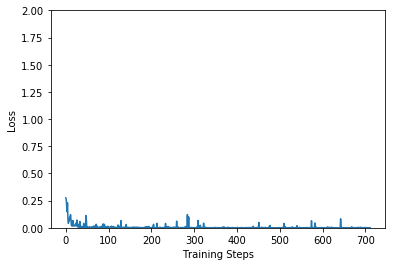

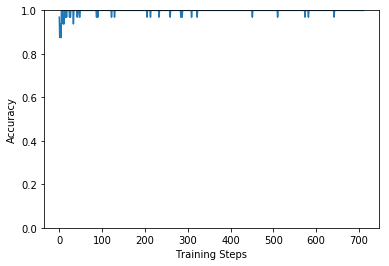

In [11]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

In [12]:
class_names = sorted(train_image_data.class_indices.items(), key=lambda pair: pair[1])
class_names = np.array([key.title() for key, value in class_names])
print(class_names)

['Boat' 'Nature']


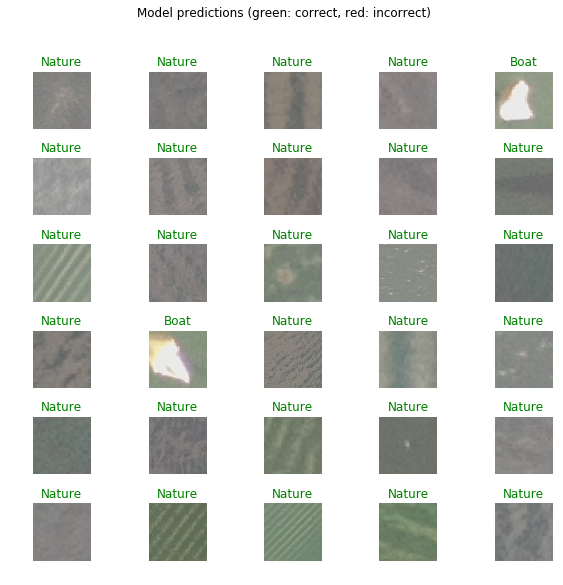

In [13]:
predicted_batch = model.predict(train_image_batch)
plot_predicted_batch(train_image_batch, train_label_batch, predicted_batch)

In [14]:
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
tf.keras.experimental.export_saved_model(model, export_path)

print(export_path)

W0727 14:09:57.649205 139777020905280 deprecation.py:323] From <ipython-input-14-f2ee6a040600>:4: export_saved_model (from tensorflow.python.keras.saving.saved_model_experimental) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `model.save(..., save_format="tf")` or `tf.keras.models.save_model(..., save_format="tf")`.
W0727 14:09:59.454574 139777020905280 deprecation.py:506] From /home/badc0ded/anaconda3/envs/colab/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1784: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
W0727 14:10:01.778777 139777020905280 deprecation.py:506] From /home/badc0ded/anaconda3/envs/colab/lib/python3.6/site-packages/tensorflow_core/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from te

/tmp/saved_models/1564236597


In [15]:
reloaded = tf.keras.experimental.load_from_saved_model(export_path,
                                                       custom_objects={'KerasLayer': hub.KerasLayer})

result_batch = model.predict(train_image_batch)
reloaded_result_batch = reloaded.predict(train_image_batch)

print(abs(reloaded_result_batch - result_batch).max())

W0727 14:10:28.124447 139777020905280 deprecation.py:323] From <ipython-input-15-722ca42bcf3b>:2: load_from_saved_model (from tensorflow.python.keras.saving.saved_model_experimental) is deprecated and will be removed in a future version.
Instructions for updating:
The experimental save and load functions have been  deprecated. Please switch to `tf.keras.models.load_model`.


0.0


In [21]:
test_data_root = os.path.join(DATA_PATH, "test")
test_image_data = read_data(test_data_root)

test_loss, test_acc = model.evaluate(test_image_data)

print('Test accuracy: {}'.format(test_acc))

Found 4614 images belonging to 2 classes.
145/145 [==============================] - 134s 927ms/step - loss: 0.0063 - acc: 0.9983
Test accuracy: 0.9982661604881287


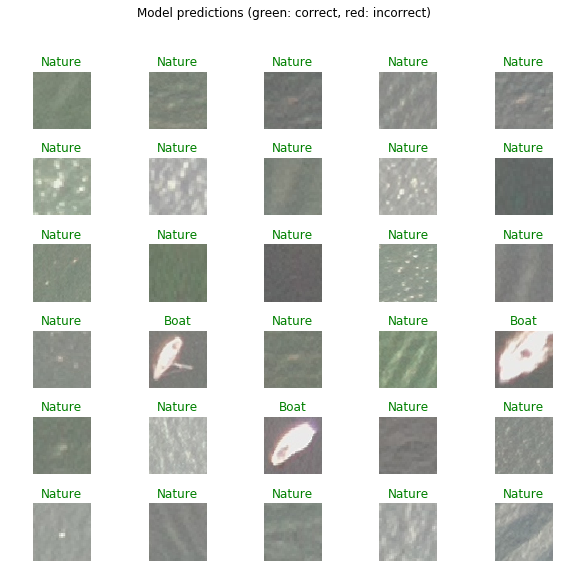

In [20]:
test_image_batch, test_label_batch = test_image_data[2]
predicted_batch = model.predict(test_image_batch)
plot_predicted_batch(test_image_batch, test_label_batch, predicted_batch)